In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [21]:
import sys
sys.path.append('..')

from rlmolecule.sql.run_config import RunConfig
run_config = RunConfig('../config/config_eagle_c.yaml')

In [4]:
import rdkit
from examples.stable_radical_optimization.stable_radical_molecule_state import MoleculeBuilderWithFingerprint, StableRadMoleculeState
#  from rlmolecule.molecule.molecule_state import MoleculeState

prob_config = run_config.problem_config
    
builder = MoleculeBuilderWithFingerprint(
    max_atoms=prob_config.get('max_atoms', 15),
    min_atoms=prob_config.get('min_atoms', 4),
    try_embedding=prob_config.get('try_embedding', True),
    sa_score_threshold=prob_config.get('sa_score_threshold', 3.5),
    stereoisomers=prob_config.get('stereoisomers', True),
    canonicalize_tautomers=prob_config.get('canonicalize_tautomers', True),
    atom_additions=prob_config.get('atom_additions', ('C', 'N', 'O', 'S')),
    cache_dir=None,
    num_shards=prob_config.get('num_shards', 1),
    parallel=False)

state = StableRadMoleculeState(rdkit.Chem.MolFromSmiles('CC(N)S'), builder=builder)
state.get_next_actions()

[N[C@@H]1CS1,
 N[C@H]1CS1,
 CN[C@H](C)S,
 CN[C@@H](C)S,
 [CH2]C(N)S (t),
 C[C](N)S (t),
 CC([NH])S (t),
 CC(N)[S] (t)]

In [5]:
from time import time

In [22]:
prob_config.get('try_embedding', True)

False

In [6]:
import os, sys
import rdkit
from examples.stable_radical_optimization.stable_radical_molecule_state import MoleculeBuilderWithFingerprint, StableRadMoleculeState
#  from rlmolecule.molecule.molecule_state import MoleculeState

prob_config = run_config.problem_config

max_atoms = 4

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def get_search_space(max_atoms):

    builder = MoleculeBuilderWithFingerprint(
        max_atoms=max_atoms,
        min_atoms=min(4, max_atoms),
        try_embedding=prob_config.get('try_embedding', True),
        sa_score_threshold=prob_config.get('sa_score_threshold', 3.5),
        stereoisomers=prob_config.get('stereoisomers', True),
        canonicalize_tautomers=prob_config.get('canonicalize_tautomers', True),
        atom_additions=prob_config.get('atom_additions', ('C', 'N', 'O', 'S')),
        cache_dir=None,
        num_shards=prob_config.get('num_shards', 1),
        parallel=False)

    start = StableRadMoleculeState(rdkit.Chem.MolFromSmiles('C'), builder=builder)

    visited = set()

    def dfs(visted, state):
        if not state.forced_terminal:
            for child in state.get_next_actions():
                if child not in visited:
                    visited.add(child)
                    yield child
                    yield from dfs(visited, child)
                    
    start_time = time()
    with HiddenPrints():
        size = len(set(dfs(visited, start)))

    return size, time() - start_time

In [7]:
# from itertools import islice
# from tqdm.auto import tqdm
# import random

# shuffled = lambda x: sorted(x, key=lambda k: random.random())

# max_atoms = 12

# builder = MoleculeBuilderWithFingerprint(
#     max_atoms=max_atoms,
#     min_atoms=min(4, max_atoms),
#     try_embedding=prob_config.get('try_embedding', True),
#     sa_score_threshold=prob_config.get('sa_score_threshold', 3.5),
#     stereoisomers=prob_config.get('stereoisomers', True),
#     canonicalize_tautomers=prob_config.get('canonicalize_tautomers', True),
#     atom_additions=prob_config.get('atom_additions', ('C', 'N', 'O', 'S')),
#     cache_dir=None,
#     num_shards=prob_config.get('num_shards', 1),
#     parallel=True)

# start = StableRadMoleculeState(rdkit.Chem.MolFromSmiles('C'), builder=builder)

# visited = set()

# def dfs(visted, state):
#     if not state.forced_terminal:
#         for child in state.get_next_actions():
#             if child not in visited:
#                 visited.add(child)
#                 yield child
#                 yield from dfs(visited, child)

# start_time = time()
# with HiddenPrints():
#     pbar = tqdm(enumerate(dfs(visited, start)))
#     for i, state in pbar:
#         if (i % 10 == 0) & (i > 0):
#             pbar.set_description(f'total = {i}, tps = {(time() - start_time) / i}')


In [20]:
prob_config.get('try_embedding', True)

False

In [8]:
from tqdm.auto import tqdm

In [ ]:
results = []
for i in tqdm(np.arange(1, 9)):
    results += [get_search_space(i)]
    print(results[-1])

  0%|          | 0/8 [00:00<?, ?it/s]

(1, 0.0005691051483154297)
(8, 0.012215852737426758)


RDKit ERROR: [14:47:59] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:47:59] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:47:59] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:47:59] Explicit valence for atom # 1 C, 5, is greater than permitted


(108, 0.19858813285827637)


RDKit ERROR: [14:48:01] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:48:01] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:48:01] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:48:01] Explicit valence for atom # 1 C, 5, is greater than permitted


(694, 1.7418138980865479)


RDKit ERROR: [14:48:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:48:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:48:11] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:48:11] Explicit valence for atom # 1 C, 5, is greater than permitted


(3915, 11.330543994903564)


RDKit ERROR: [14:49:17] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:49:17] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:49:17] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:49:17] Explicit valence for atom # 1 C, 5, is greater than permitted


(20935, 66.42955875396729)


RDKit ERROR: [14:56:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:56:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:56:12] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [14:56:12] Explicit valence for atom # 1 C, 5, is greater than permitted


(117577, 417.0220468044281)


In [23]:
results[-1]

(706755, 2923.836696624756)

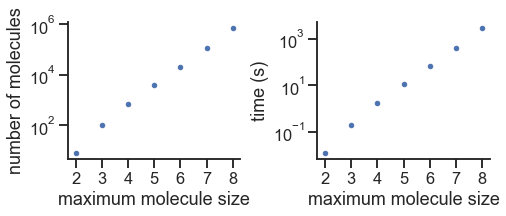

In [12]:
times = list([r[1] for r in results])
# times[0] = 0.597
# times[1] = 1.01
# times[2] = 4.73

fig, ax = plt.subplots(ncols=2, figsize=(7, 3), sharex=True)

ax[0].semilogy(np.arange(2, 9), [r[0] for r in results[1:]], '.')
ax[1].semilogy(np.arange(2, 9), times[1:], '.')

ax[0].set_xticks(np.arange(2, 9))
ax[1].set_ylabel('time (s)')
ax[0].set_ylabel('number of molecules')
ax[0].set_xlabel('maximum molecule size')
ax[1].set_xlabel('maximum molecule size')

plt.tight_layout()
sns.despine()
plt.savefig('20211207_results_to_8.svg')

In [13]:
times / np.asarray([r[0] for r in results])

array([0.00056911, 0.00152698, 0.00183878, 0.00250982, 0.00289414,
       0.00317313, 0.0035468 , 0.00413699])

In [14]:
from scipy.stats import linregress

In [33]:
regression = linregress(np.arange(2, 9), [np.log(r[0]) for r in results[1:]])
f"{np.exp(regression.intercept + regression.slope * 15):e}"

'3.258032e+11'

In [ ]:
np.log(np.asarray(times[-4:]))

In [35]:
regression = linregress(np.arange(2, 9), np.log(np.asarray(times[1:])))
np.exp(regression.intercept + regression.slope * 15) / (365.25*24*60*60)

139.042039446584

In [ ]:


plt.errorbar(np.arange(1, 8), times, yerr=[.026, .036, .040, 0, 0, 0, 0], marker='.', elinewidth=1)
plt.yscale('log')

In [ ]:
%timeit get_search_space(1)

In [ ]:
%timeit get_search_space(2)

In [ ]:
%timeit get_search_space(3)

In [ ]:
len(get_search_space(1))results

In [ ]:
len(get_search_space(2))

In [ ]:
len(get_search_space(3))

In [ ]:
len(get_search_space(4))

In [ ]:
len(get_search_space(5))

In [ ]:
len(get_search_space(8))

In [ ]:
# for i in range(8):
#     search_space = get_search_space(i)
#     print(f"{i}: {len(search_space)}", flush=True)

In [ ]:
state.get_next_actions()[0].get_next_actions()

In [ ]:
import sys
sys.path.append('/home/pstjohn/Packages/bde/')
from bde.fragment import enumerate_stereocenters

In [ ]:
rdkit.__version__

In [ ]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.MolStandardize import rdMolStandardize
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

In [ ]:
mol = rdkit.Chem.MolFromSmiles('CC(N)(O)S')
[rdkit.Chem.MolToSmiles(mol) for mol in EnumerateStereoisomers(mol)]

In [ ]:
canonical_mol = tautomer_enumerator.Canonicalize(mol)
rdkit.Chem.FindMolChiralCenters(canonical_mol, includeUnassigned=True)
[rdkit.Chem.MolToSmiles(mol) for mol in EnumerateStereoisomers(canonical_mol)]

In [ ]:
rdkit.Chem.SanitizeMol(canonical_mol, rdkit.Chem.SANITIZE_CLEANUPCHIRALITY)

In [ ]:
[rdkit.Chem.MolToSmiles(mol) for mol in EnumerateStereoisomers(canonical_mol)]

In [ ]:
rdkit.Chem.AssignStereochemistry(canonical_mol, cleanIt=True, flagPossibleStereoCenters=True)

In [ ]:
to_plot = pd.read_csv('possible_hits.csv')

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
enumerator = rdMolStandardize.TautomerEnumerator()

In [ ]:
to_plot.smiles.apply(lambda x: len(list(enumerator.Enumerate(rdkit.Chem.MolFromSmiles(x)))))

In [ ]:
import rdkit
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(to_plot.smiles.apply(rdkit.Chem.MolFromSmiles), molsPerRow=4, subImgSize=(250,200), 
                legends=to_plot.apply(lambda x: f'{x.smiles}\n{x.substruct}\n#atoms={x.num_atoms}', 1).values.tolist(), useSVG=True)

In [ ]:
redox_df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')
redox_new_calcs = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210216_fixed_rl_redox_data.csv')
tempo_results = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/tempo_results.csv')
redox_new_calcs = redox_new_calcs.append(tempo_results)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def canonicalize(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    can = enumerator.Canonicalize(mol)
    return rdkit.Chem.MolToSmiles(mol)

In [ ]:
redox_df['can_smiles'] = redox_df.smiles.progress_apply(canonicalize)

In [ ]:
redox_df[redox_df.can_smiles != redox_df.smiles]